## Ensemble forecast with initial state perturbation

The following steps are so far applicable only with the MLP. Here, we slightly perturb model forecast **at the first predicted time step after initialisation**, by a magnitude defined by sigma. This timestep is currently $t_0$ for the LSTM which estimates initial conditions from the lookback, but it is $t_1$ for the MLP and XGB that are initialised with observations at $t_0$. We run multiple deterministic forecasts with this disturbance (defined as ensemble here).

In [1]:
import torch
import os
import sys
import matplotlib.pyplot as plt

parent_dir = os.path.abspath('..')
sys.path.append(parent_dir)

from data_module import *
from evaluation_module import *
from forecast_module import *
from observation_module import *
from visualisation_module import *

from helpers import *
from tests.test_model import *


set_global_seed(42)

SCRIPT_DIR = os.getcwd()
sys.path.append(os.path.dirname(SCRIPT_DIR))
print(SCRIPT_DIR) 

path_to_plots = '../plots/'
path_to_results = '../results/'

#EX_CONFIG = load_config(config_path = '../../configs/smosmania_st.yaml')
EX_CONFIG = load_config(config_path = '../../configs/tereno_st.yaml')

network =  EX_CONFIG['network'] #'soil_TERENO_ISMN_2022.nc'#'soil_SMOSMANIA_ISMN_2022.nc' # 'soil_TERENO_ISMN_2022.nc'
network_name = network.split('_')[1]
station = EX_CONFIG['station'] # 'Lahas'

variable = EX_CONFIG['variable'] 
depth = EX_CONFIG['depth']  # [0.05, 0.2, 0.3]

years = EX_CONFIG['years']
models = EX_CONFIG['models']# , 'xgb'

maximum_leadtime = EX_CONFIG['maximum_leadtime'] # medium range, ten days
tolerance = EX_CONFIG['tolerance']
score = EX_CONFIG['score']

print("Network: ", network)
print("Station: ", station)
print("Variable: ", variable)
print("Depth: ", depth)
print("Years: ", years)
print("Models: ", models)
print("Initial time: ", EX_CONFIG['initial_time'])

/etc/ecmwf/nfs/dh1_home_a/pamw/PycharmProjects/forecast-horizons/ecland-emulator
cpu
/etc/ecmwf/nfs/dh1_home_a/pamw/PycharmProjects/forecast-horizons/ecland-emulator/notebooks
Opening ../../configs/tereno_st.yaml for experiment configuration.
Network:  soil_TERENO_ISMN_2022.nc
Station:  Gevenich
Variable:  st
Depth:  [0.05, 0.2, 0.5]
Years:  [2021, 2022]
Models:  ['mlp', 'lstm', 'xgb']
Initial time:  2022-02-01T00:00:00


/perm/pamw/venvs/myevalenv/lib/python3.12/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
Gevenich = ObservationModule(network = network, 
                             station = station,
                             variable = variable,
                             depth=depth) # Initialise the Observation Module with the default Station (Gevenich)

Gevenich.load_station(years = years) # Load two years of station data for lookback slicing
Gevenich.load_forcing() # Load forcing for matching data base with station data
closest_grid_cell = Gevenich.match_station_with_forcing() # Match the station with clostest grid cell and extract the index of the grid cell
Gevenich.process_station_data() # specify path_to_plots, if you want to visualise

Select station:  Gevenich
Select depth:  [0.05, 0.2, 0.5]
Extracted year: 2022
Matched station with grid cell:  4106
Converting celsius into kelvin
Resampling to 6-hourly mean.


In [3]:
def perturb_initial_state(initial_state, perturbation_factor = 0.005):
    random_perturbation = torch.rand(initial_state.size()) * 2 - 1  # random values between -1 and 1
    return initial_state * (1 + perturbation_factor * random_perturbation)

def create_perturbation_ensemble(initial_state, size = 50):
    torch.manual_seed(42)
    perturbation_ensemble = [perturb_initial_state(initial_state) for i in range(size)]
    return perturbation_ensemble


In [4]:
dynamic_features_ensemble = {}
dynamic_features_prediction_ensemble = {}

for mod in ["mlp", "lstm", "xgb"]:

    if mod == 'mlp':
        print('mlp')
        CONFIG = load_config(config_path = '../../configs/mlp_emulator.yaml')
        HPARS = load_hpars(use_model = '../mlp')
        ForecastModel = ForecastModuleMLP(hpars=HPARS, config=CONFIG)    
    elif mod == 'lstm':
        CONFIG = load_config(config_path = '../../configs/lstm_emulator.yaml')
        HPARS = load_hpars(use_model = '../lstm')
        ForecastModel = ForecastModuleLSTM(hpars=HPARS, config=CONFIG)
    elif mod == 'xgb':
        CONFIG = load_config(config_path = '../../configs/xgb_emulator.yaml')
        HPARS = None
        ForecastModel = ForecastModuleXGB(hpars=HPARS, config=CONFIG)

    CONFIG['x_slice_indices'] = closest_grid_cell # adjust the index of the grid cell in the config file before initialising the models

    dataset = ForecastModel.initialise_dataset(EX_CONFIG['initial_time'])
    model = ForecastModel.load_model()
    x_static, x_met, y_prog, y_prog_initial_state = ForecastModel.load_test_data(dataset)  
    print("INITIAL STATE SHAPE:", y_prog_initial_state.shape)

    station_data = Gevenich.slice_station_data(lookback=CONFIG["lookback"],
                                    t_0=EX_CONFIG['initial_time'])
    matching_indices = Gevenich.match_indices(dataset=dataset,
                                              target_variables=EX_CONFIG['targets_eval'])
    y_prog_initial_state[..., matching_indices] = station_data[:y_prog_initial_state.shape[0]]
    
    perturbed_ensemble = create_perturbation_ensemble(y_prog_initial_state)

    ensemble_prediction = []
    for i in range(len(perturbed_ensemble)):
        matching_indices = Gevenich.match_indices(dataset=dataset,
                                              target_variables=EX_CONFIG['targets_prog'])
        initial_vector =  Gevenich.transform_station_data(station_data = perturbed_ensemble[i],
                                                  target_variable_list = EX_CONFIG['targets_prog'])

        dynamic_features, dynamic_features_prediction = ForecastModel.run_forecast(initial_conditions=initial_vector, 
                                                                                initial_conditions_perturbation=None,
                                                                                predictions_perturbation = None)
        dynamic_features, dynamic_features_prediction = ForecastModel.backtransformation()
        ensemble_prediction.append(dynamic_features_prediction)

    dynamic_features_ensemble[mod] = dynamic_features
    dynamic_features_prediction_ensemble[mod] = ensemble_prediction

mlp
Opening ../../configs/mlp_emulator.yaml for experiment configuration.
{'batch_size': 4, 'clim_feats': ['clim_clake', 'clim_ldepth', 'clim_ctype', 'clim_cell_area', 'clim_glm', 'clim_cu', 'clim_cvh', 'clim_cvl', 'clim_tvh', 'clim_tvl', 'clim_sotype', 'clim_geopot', 'clim_sdfor', 'clim_sdor', 'clim_theta_cap', 'clim_theta_pwp', 'clim_veg_covh', 'clim_veg_covl', 'clim_veg_z0mh', 'clim_veg_z0ml', 'clim_veg_rsminh', 'clim_veg_rsminl'], 'continue_training': False, 'db_path': '/ec/res4/hpcperm/daep/ec_land_training_db/ecland_i6aj_o400_2010_2022_6h_euro.zarr', 'device': 'cpu', 'devices': 1, 'diag_transform': 'zscoring', 'dropout': 0.1852693061424568, 'dyn_transform': 'zscoring', 'dynamic_feats': ['met_ctpf', 'met_lwdown', 'met_psurf', 'met_qair', 'met_rainf', 'met_swdown', 'met_snowf', 'met_tair', 'met_wind_e', 'met_wind_n', 'lai_hv', 'lai_lv'], 'end_year': 2019, 'file_path': '/ec/res4/hpcperm/daep/ec_land_training_db/ecland_i6aj_o400_2010_2022_6h_euro.zarr', 'hidden_dim': [122, 47, 103, 1

/etc/ecmwf/nfs/dh1_home_a/pamw/PycharmProjects/forecast-horizons/ecland-emulator/forecast_module.py:181: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.loa

Model to device: cpu
INITIAL STATE SHAPE: torch.Size([1, 7])
Selecting from index: 1584
Subtract lookback for new index: 1584
Initialised prediction.
Setting model to evaluation mode
on step 0...
on step 1000...
--- 0.1810600757598877 seconds ---
--- 0.0030176679293314615 minutes ---
y_prog shape:  torch.Size([1211, 1, 7])
y_prog_prediction shape:  torch.Size([1211, 1, 7])
Backtransforming
Initialised prediction.
Setting model to evaluation mode
on step 0...
on step 1000...
--- 0.17836356163024902 seconds ---
--- 0.002972726027170817 minutes ---
y_prog shape:  torch.Size([1211, 1, 7])
y_prog_prediction shape:  torch.Size([1211, 1, 7])
Backtransforming
Initialised prediction.
Setting model to evaluation mode
on step 0...
on step 1000...
--- 0.17847681045532227 seconds ---
--- 0.0029746135075887042 minutes ---
y_prog shape:  torch.Size([1211, 1, 7])
y_prog_prediction shape:  torch.Size([1211, 1, 7])
Backtransforming
Initialised prediction.
Setting model to evaluation mode
on step 0...
on

In [5]:
print(dynamic_features_prediction_ensemble['mlp'][0].shape)
print(dynamic_features_prediction_ensemble['lstm'][0].shape)
print(dynamic_features_prediction_ensemble['xgb'][0].shape)

ensemble_dict = dynamic_features_prediction_ensemble
for key, ensemble_prediction in ensemble_dict.items():
    ensemble_dict[key] = np.stack(ensemble_prediction).squeeze()[:,:maximum_leadtime,:]

print(ensemble_dict['mlp'].shape)
print(ensemble_dict['lstm'].shape)
print(ensemble_dict['xgb'].shape)

fc_numerical = dynamic_features_ensemble['lstm'][0].squeeze()[:maximum_leadtime]
observations = station_data[:maximum_leadtime]

torch.Size([1211, 1, 7])
torch.Size([1211, 1, 7])
(1210, 1, 7)
(50, 120, 7)
(50, 120, 7)
(50, 120, 7)


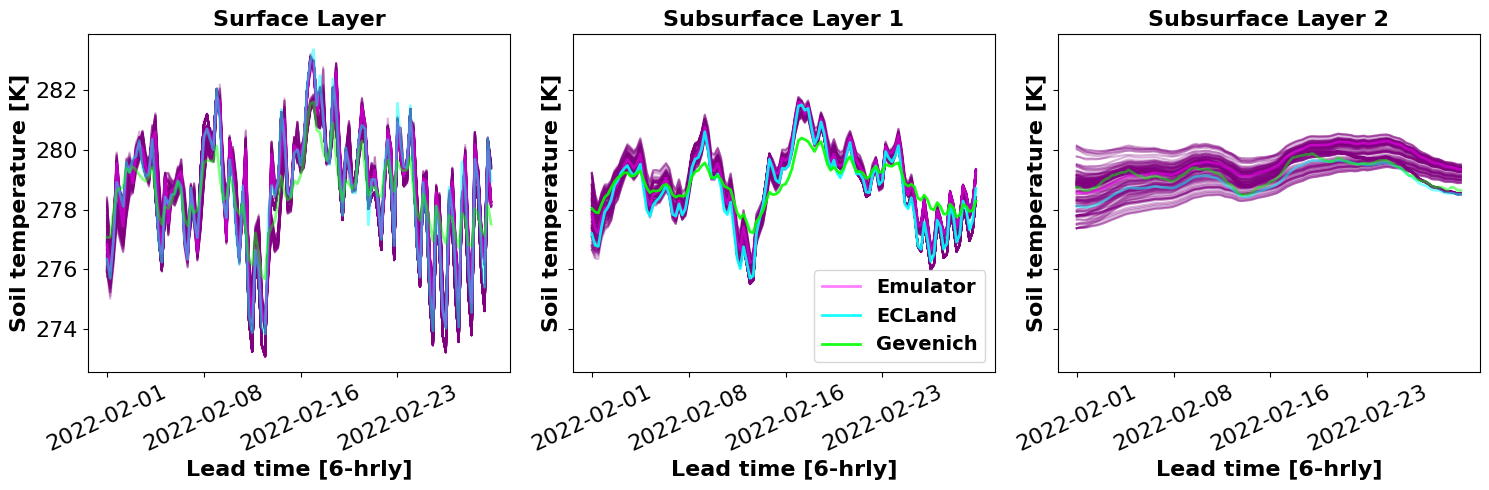

In [6]:
PlotStation = VisualisationSingle(
                 network = EX_CONFIG["network"], 
                 station = "all", 
                 variable = EX_CONFIG["variable"], 
                 maximum_leadtime = EX_CONFIG["maximum_leadtime"], 
                 score = EX_CONFIG["score"],
                 doy_vector = Gevenich.doy_vector,
                 evaluation = "ens", 
                 path_to_plots = path_to_plots
)

PlotStation.plot_initial_state_perturbation(ensemble_dict, fc_numerical, observations, EX_CONFIG['ensemble_size'])